In [1]:
!rm -rf whichfaceisreal.tar.gz

!gdown 1s9okorKly_IyGYUf8KedXk8qJ0zIc4QH
!tar -xvf whichfaceisreal.tar.gz

'rm' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'gdown' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
tar: Error opening archive: Failed to open 'whichfaceisreal.tar.gz'


In [2]:
!rm -rf "univfd.zip" "UniversalFakeDetect-main"

!wget -O univfd.zip 'https://github.com/WisconsinAIVision/UniversalFakeDetect/archive/refs/heads/main.zip'
!unzip univfd.zip

'rm' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'wget' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'unzip' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [3]:
%pip install ftfy

   ---------------------------------------- 0.0/43.0 kB ? eta -:--:--
   ---------------------------- ----------- 30.7/43.0 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 43.0/43.0 kB 697.3 kB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth-0.2.5
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
sys.path.append('./UniversalFakeDetect/')

from PIL import Image, ImageOps
import torch

from models import get_model

ModuleNotFoundError: No module named 'models'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 載入模型

UnivFD模型以兩個部分組成，作者借用openai的CLIP模型的image encoder作為特徵擷取，再訓練一層FC作為下游任務的分類器。

所以要做兩件事:
1. 載入CLIP的image encoder模型以及預訓練的權重
2. 載入本篇論文訓練的最後一層FC

In [6]:
model = get_model("CLIP:ViT-L/14")
model

CLIPModel(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuan

In [7]:
fc_weight = torch.load("./UniversalFakeDetect-main/pretrained_weights/fc_weights.pth", map_location="cpu", weights_only=True)
model.fc.load_state_dict(fc_weight)

model = model.eval()
model = model.to(device)

### 載入前處理的Function

CLIP模型已經附帶前處理的模組，只需直接使用，他做了以下事情:
- 影像縮放到224*224
- 轉成Tensor
- 套用Normalize

In [8]:
preprocess = model.preprocess
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x79c6ef8db5b0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

### 嘗試進行推論

在這邊讀取測試影像，並輸入模型進行推論，取得辨識結果

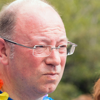

In [9]:
image_path = './whichfaceisreal/0_real/10286.jpeg'
image = Image.open(image_path)
ImageOps.fit(image, (100, 100))

In [10]:
tensor = preprocess(image)
batch = torch.stack([tensor])
batch = batch.to(device)
print(batch.shape)

torch.Size([1, 3, 224, 224])


In [11]:
with torch.no_grad():
    out = model(batch)
    out = out.sigmoid()
out = out.cpu()
print(out)

tensor([[0.0028]])


In [12]:
def inference(image_path):
    image = Image.open(image_path)
    display(ImageOps.fit(image, (100, 100))) # ipython內建顯示PIL Image

    tensor = preprocess(image)
    batch = torch.stack([tensor])
    batch = batch.to(device)

    with torch.no_grad():
        out = model(batch)
        out = out.sigmoid()
    out = out.cpu()
    print(out)

    out = out[0][0]
    if out > 0.5:
        print('AI image')
    else:
        print('Not AI image')


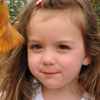

tensor([[0.0009]])
Not AI image


In [13]:
inference('./whichfaceisreal/0_real/26383.jpeg')

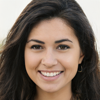

tensor([[0.9930]])
AI image


In [14]:
inference('./whichfaceisreal/1_fake/image-2019-02-17_033657.jpeg')